In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
# Import library

import torch
from torchvision import transforms, models
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import os
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, roc_auc_score
import seaborn as sns
import cv2

plt.style.use("ggplot")
import timm
import torchsummary
import sys

In [6]:
current_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(current_dir, ".."))
if project_root not in sys.path:
    sys.path.append(project_root)
root_name = os.path.basename(project_root)
root_name

'deep_fake_detection'

In [7]:
from src.utils import set_seed, get_device, save_experiment_json, save_checkpoint, plot_history, performance
from src.dataloader import get_data_loaders
from src.model import XceptionDF
from src.train import get_all_predictions, train_one_epoch, evaluate
set_seed(42)

In [8]:
CLASS = ['real', 'fake']
BATCH_SIZE = 32
DEVICE = get_device()
TASK_NAME = 'deepfake_detection'
EPOCHS_STAGE_1 = 10 # General configuration
LR_STAGE_1 = 1e-3 # General configuration
EPOCHS_STAGE_2 = 20 # General configuration
LR_STAGE_2 = 1e-5 # General configuration
MODEL_NAME = "Xception"

print(f"Using device: {DEVICE}")

Using device: mps


## 1. Xception Training without Data Augmentation, Label Smoothing and Weight Decay

In [9]:
data_path = os.path.join(project_root, "data")

In [10]:
# Loading data with no augmentation
train_loader, val_loader, test_loader = get_data_loaders(root_dir = data_path, 
                                                         model_name = MODEL_NAME, 
                                                         batch_size = BATCH_SIZE, 
                                                         use_augmentation = False)

In [11]:
def get_labels(logits):
    return torch.argmax(nn.Softmax(dim = -1)(logits), dim = 1).cpu().detach().flatten().tolist()

### 1.1 Train classifier Head only

In [12]:
model = XceptionDF()

/Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/.venv/lib/python3.11/site-packages/timm/models/_factory.py:138: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(


In [13]:
torchsummary.summary(model, (3, 299, 299), batch_size=32)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [32, 32, 149, 149]             864
       BatchNorm2d-2         [32, 32, 149, 149]              64
              ReLU-3         [32, 32, 149, 149]               0
            Conv2d-4         [32, 64, 147, 147]          18,432
       BatchNorm2d-5         [32, 64, 147, 147]             128
              ReLU-6         [32, 64, 147, 147]               0
            Conv2d-7         [32, 64, 147, 147]             576
            Conv2d-8        [32, 128, 147, 147]           8,192
   SeparableConv2d-9        [32, 128, 147, 147]               0
      BatchNorm2d-10        [32, 128, 147, 147]             256
             ReLU-11        [32, 128, 147, 147]               0
           Conv2d-12        [32, 128, 147, 147]           1,152
           Conv2d-13        [32, 128, 147, 147]          16,384
  SeparableConv2d-14        [32, 128, 1

In [16]:
model = model.to(device=DEVICE)
optimizer = torch.optim.Adam(params=model.parameters(), lr = LR_STAGE_1)
criterion = nn.CrossEntropyLoss()

In [17]:
history = {
    "model_name": MODEL_NAME,
    "train_losses": [],
    "val_losses": [],
    "train_accuracy": [],
    "val_accuracy": [],
    "val_f1": [],
    "val_auc": [],
    "best_accuracy": 0.0,
    "best_epoch": 0,
    "MODEL_SAVED_PATH": "",
}

best_acc = 0.0

In [18]:

MODEL_SAVED_PATH = os.path.join(
    project_root, f"model_checkpoints/{MODEL_NAME}_{TASK_NAME}.pth"
)

print(f"Training configuration for stage 1: LR = {LR_STAGE_1}, EPOCHS = {EPOCHS_STAGE_1}")

for epoch in range(EPOCHS_STAGE_1):
    # Train
    train_loss, train_acc = train_one_epoch(
        model, train_loader, criterion, optimizer, DEVICE
    )

    # Evaluate
    valid_loss, valid_acc, valid_f1, valid_auc = evaluate(
        model, val_loader, criterion, DEVICE
    )

    print(
        f"[{epoch + 1}/{EPOCHS_STAGE_1}] train_acc: {train_acc:.4f} - train_loss: {train_loss:.4f} - valid_acc: {valid_acc:.4f} - valid_loss: {valid_loss:.4f}"
    )
    # Record metrics
    history["train_losses"].append(train_loss)
    history["val_losses"].append(valid_loss)
    history["train_accuracy"].append(train_acc)
    history["val_accuracy"].append(valid_acc)
    history["val_f1"].append(valid_f1)
    history["val_auc"].append(valid_auc)

    # Save Best Model (based on Accuracy)
    if valid_acc > best_acc:
        best_acc = valid_acc
        save_checkpoint(model, optimizer, MODEL_SAVED_PATH)

        # Update best stats
        history["best_accuracy"] = best_acc
        history["best_epoch"] = epoch + 1
        history["MODEL_SAVED_PATH"] = MODEL_SAVED_PATH

    print(
        f"\t- [current best] epoch: {history['best_epoch']} - acc: {history['best_accuracy']:.4f}\n"
    )

Training configuration for stage 1: LR = 0.001, EPOCHS = 10


Evaluating: 100%|██████████| 94/94 [00:51<00:00,  1.81it/s]


[1/10] train_acc: 0.5698 - train_loss: 0.6775 - valid_acc: 0.6044 - valid_loss: 0.6596
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/model_checkpoints/Xception_deepfake_detection.pth
	- [current best] epoch: 1 - acc: 0.6044



Evaluating: 100%|██████████| 94/94 [01:00<00:00,  1.56it/s]


[2/10] train_acc: 0.6123 - train_loss: 0.6560 - valid_acc: 0.6201 - valid_loss: 0.6491
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/model_checkpoints/Xception_deepfake_detection.pth
	- [current best] epoch: 2 - acc: 0.6201



Evaluating: 100%|██████████| 94/94 [01:02<00:00,  1.51it/s]


[3/10] train_acc: 0.6164 - train_loss: 0.6515 - valid_acc: 0.6148 - valid_loss: 0.6548
	- [current best] epoch: 2 - acc: 0.6201



Evaluating: 100%|██████████| 94/94 [01:01<00:00,  1.52it/s]


[4/10] train_acc: 0.6233 - train_loss: 0.6470 - valid_acc: 0.6181 - valid_loss: 0.6519
	- [current best] epoch: 2 - acc: 0.6201



Evaluating: 100%|██████████| 94/94 [01:01<00:00,  1.52it/s]


[5/10] train_acc: 0.6199 - train_loss: 0.6484 - valid_acc: 0.5446 - valid_loss: 0.7577
	- [current best] epoch: 2 - acc: 0.6201



Evaluating: 100%|██████████| 94/94 [01:01<00:00,  1.52it/s]


[6/10] train_acc: 0.6218 - train_loss: 0.6489 - valid_acc: 0.6201 - valid_loss: 0.6549
	- [current best] epoch: 2 - acc: 0.6201



Evaluating: 100%|██████████| 94/94 [01:01<00:00,  1.52it/s]


[7/10] train_acc: 0.6207 - train_loss: 0.6494 - valid_acc: 0.6252 - valid_loss: 0.6416
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/model_checkpoints/Xception_deepfake_detection.pth
	- [current best] epoch: 7 - acc: 0.6252



Evaluating: 100%|██████████| 94/94 [01:01<00:00,  1.52it/s]


[8/10] train_acc: 0.6247 - train_loss: 0.6458 - valid_acc: 0.6195 - valid_loss: 0.6470
	- [current best] epoch: 7 - acc: 0.6252



Evaluating: 100%|██████████| 94/94 [01:02<00:00,  1.51it/s]


[9/10] train_acc: 0.6276 - train_loss: 0.6453 - valid_acc: 0.6064 - valid_loss: 0.6578
	- [current best] epoch: 7 - acc: 0.6252



Evaluating: 100%|██████████| 94/94 [01:01<00:00,  1.52it/s]

[10/10] train_acc: 0.6225 - train_loss: 0.6501 - valid_acc: 0.6218 - valid_loss: 0.6427
	- [current best] epoch: 7 - acc: 0.6252



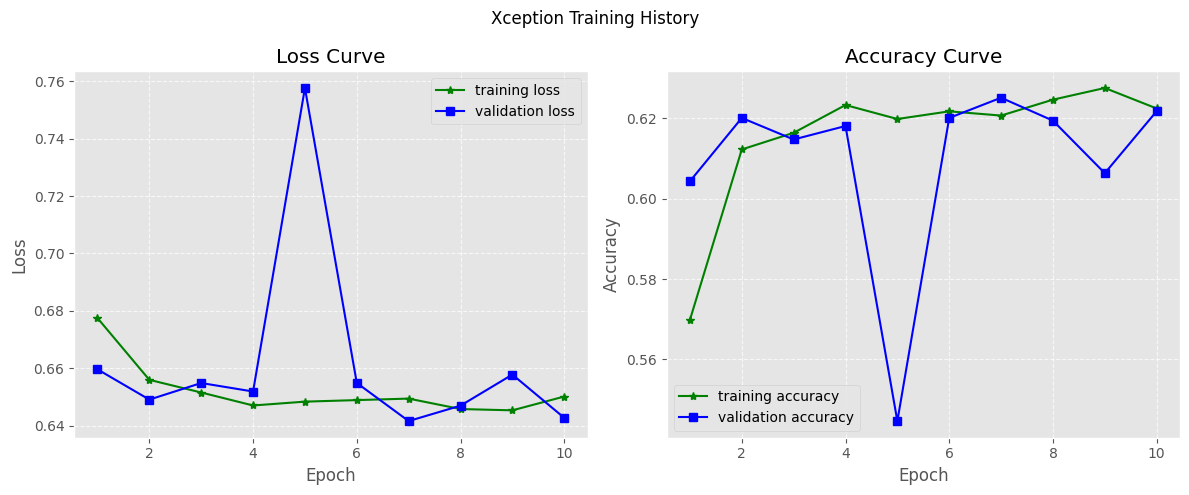

In [19]:
# Plot training history
plot_history(history, "Xception Training History")

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
def visualize_model_prediction(model, dataloader,  num_images=6):
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(12, 7))

    with torch.no_grad():
        for i, (originals, inputs, labels) in enumerate(dataloader):
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)
            print(originals.shape)
            outputs = model(inputs)
            preds = get_labels(outputs)

            # Get random index
            random_indices = np.random.choice(np.arange(inputs.size()[0]), size = num_images, replace=False)

            for j in random_indices:
                images_so_far += 1
                plt.subplot(num_images // 2, 2, images_so_far)
                plt.axis('off')
                plt.title(f"actual: {CLASS[labels[j].item()]} \n predicted: {CLASS[preds[j]]}")
                plt.tight_layout()
                plt.imshow(originals.cpu().data[j])

                if images_so_far == num_images:
                    return
visualize_model_prediction(model, val_loader, num_images=6)

/Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/.venv/lib/python3.11/site-packages/timm/models/_factory.py:138: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(


In [20]:
# Load the model again
checkpoint = torch.load(MODEL_SAVED_PATH)
model.load_state_dict(checkpoint["state_dict"])

<All keys matched successfully>

Getting predictions: 100%|██████████| 95/95 [00:59<00:00,  1.60it/s]

Accuracy score: 0.6315
Classification Report
              precision    recall  f1-score   support

           0       0.64      0.62      0.63      1510
           1       0.63      0.65      0.64      1510

    accuracy                           0.63      3020
   macro avg       0.63      0.63      0.63      3020
weighted avg       0.63      0.63      0.63      3020



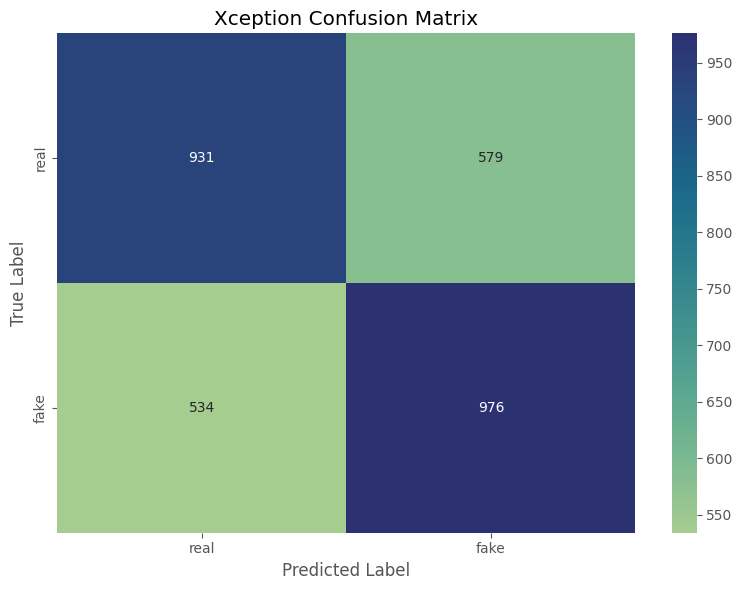

In [21]:
save_path = f"{project_root}/results/{MODEL_NAME}_{TASK_NAME}_cfm.png"
performance(model, test_loader, DEVICE, MODEL_NAME, save_path = save_path)

In [22]:
# Save history
json_path = os.path.join(project_root, f"results/{MODEL_NAME}_{TASK_NAME}_history.json")
save_experiment_json(history, json_path)

History saved to /Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/results/Xception_deepfake_detection_history.json


## 1.2 Finetuning the model: Unfreezing few layers

In [65]:
model

DeepFakeXception(
  (model): Xception(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act2): ReLU(inplace=True)
    (block1): Block(
      (skip): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (skipbn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (rep): Sequential(
        (0): SeparableConv2d(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
          (pointwise): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        )
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(in

In [23]:
# Get number of blocks
blocks = list(model.model.named_children())
print("Number of blocks: ", len(blocks))

Number of blocks:  26


In [24]:
# Unfreeze more half of the model
num_blocks_to_unfreeze = len(blocks) // 2
for name, module in blocks[-num_blocks_to_unfreeze:]:
    print("Unfreeze block: ", name)
    for param in module.parameters():
        param.requires_grad = True

torchsummary.summary(model.to('cpu'), (3, 299, 299))

Unfreeze block:  block8
Unfreeze block:  block9
Unfreeze block:  block10
Unfreeze block:  block11
Unfreeze block:  block12
Unfreeze block:  conv3
Unfreeze block:  bn3
Unfreeze block:  act3
Unfreeze block:  conv4
Unfreeze block:  bn4
Unfreeze block:  act4
Unfreeze block:  global_pool
Unfreeze block:  fc
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 149, 149]             864
       BatchNorm2d-2         [-1, 32, 149, 149]              64
              ReLU-3         [-1, 32, 149, 149]               0
            Conv2d-4         [-1, 64, 147, 147]          18,432
       BatchNorm2d-5         [-1, 64, 147, 147]             128
              ReLU-6         [-1, 64, 147, 147]               0
            Conv2d-7         [-1, 64, 147, 147]             576
            Conv2d-8        [-1, 128, 147, 147]           8,192
   SeparableConv2d-9        [-1, 128, 147, 147]        

In [25]:
model = model.to(DEVICE)
optimizer = torch.optim.Adam(params=model.parameters(), lr=LR_STAGE_2)
criterion = nn.CrossEntropyLoss()

In [26]:
TOTAL_EPOCHS = EPOCHS_STAGE_1 + EPOCHS_STAGE_2
model_save_path = f"{project_root}/model_checkpoints/best_{MODEL_NAME}_{TASK_NAME}_finetuned.pth"

print(f"Training configuration for stage 2 (fine-tuning): LR = {LR_STAGE_2}, EPOCHS = {EPOCHS_STAGE_2}")
for epoch in range(EPOCHS_STAGE_1, TOTAL_EPOCHS):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, DEVICE)
    valid_loss, valid_acc, valid_f1, valid_auc = evaluate(model, val_loader, criterion, DEVICE)
    
    history["train_losses"].append(train_loss)
    history["train_accuracy"].append(train_acc)
    history["val_losses"].append(valid_loss)
    history["val_accuracy"].append(valid_acc)
    history["val_f1"].append(valid_f1)
    history["val_auc"].append(valid_auc)
    
    print(f"[{epoch + 1}/{TOTAL_EPOCHS} (Fine-Tune)] train_acc: {train_acc:.4f} - train_loss: {train_loss:.4f} - valid_acc: {valid_acc:.4f} - valid_loss: {valid_loss:.4f}")
    
    if valid_acc > best_acc:
        best_acc = valid_acc
        
        save_checkpoint(model, optimizer, model_save_path) 
        
        # Update best stats
        history["best_accuracy"] = best_acc
        history["best_epoch"] = epoch + 1
        history["MODEL_SAVED_PATH"] = model_save_path
        
    print(f"\t- [current best] epoch: {history['best_epoch']} - acc: {history['best_accuracy']:.4f}\n")

Training configuration for stage 2 (fine-tuning): LR = 1e-05, EPOCHS = 20


Training:   0%|          | 0/656 [00:00<?, ?it/s]

Evaluating: 100%|██████████| 94/94 [00:41<00:00,  2.28it/s]


[11/30 (Fine-Tune)] train_acc: 0.6983 - train_loss: 0.5694 - valid_acc: 0.7235 - valid_loss: 0.5429
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/model_checkpoints/best_Xception_deepfake_detection_finetuned.pth
	- [current best] epoch: 11 - acc: 0.7235



Evaluating: 100%|██████████| 94/94 [00:42<00:00,  2.23it/s]


[12/30 (Fine-Tune)] train_acc: 0.8111 - train_loss: 0.4147 - valid_acc: 0.7631 - valid_loss: 0.5067
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/model_checkpoints/best_Xception_deepfake_detection_finetuned.pth
	- [current best] epoch: 12 - acc: 0.7631



Evaluating: 100%|██████████| 94/94 [00:41<00:00,  2.28it/s]


[13/30 (Fine-Tune)] train_acc: 0.8733 - train_loss: 0.3003 - valid_acc: 0.7779 - valid_loss: 0.5037
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/model_checkpoints/best_Xception_deepfake_detection_finetuned.pth
	- [current best] epoch: 13 - acc: 0.7779



Evaluating: 100%|██████████| 94/94 [00:42<00:00,  2.22it/s]


[14/30 (Fine-Tune)] train_acc: 0.9154 - train_loss: 0.2153 - valid_acc: 0.7866 - valid_loss: 0.5345
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/model_checkpoints/best_Xception_deepfake_detection_finetuned.pth
	- [current best] epoch: 14 - acc: 0.7866



Evaluating: 100%|██████████| 94/94 [00:40<00:00,  2.32it/s]


[15/30 (Fine-Tune)] train_acc: 0.9465 - train_loss: 0.1506 - valid_acc: 0.8007 - valid_loss: 0.5488
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/model_checkpoints/best_Xception_deepfake_detection_finetuned.pth
	- [current best] epoch: 15 - acc: 0.8007



Evaluating: 100%|██████████| 94/94 [00:40<00:00,  2.32it/s]


[16/30 (Fine-Tune)] train_acc: 0.9631 - train_loss: 0.1071 - valid_acc: 0.7987 - valid_loss: 0.5997
	- [current best] epoch: 15 - acc: 0.8007



Evaluating: 100%|██████████| 94/94 [00:41<00:00,  2.27it/s]


[17/30 (Fine-Tune)] train_acc: 0.9754 - train_loss: 0.0763 - valid_acc: 0.7993 - valid_loss: 0.6618
	- [current best] epoch: 15 - acc: 0.8007



Evaluating: 100%|██████████| 94/94 [00:41<00:00,  2.27it/s]


[18/30 (Fine-Tune)] train_acc: 0.9841 - train_loss: 0.0550 - valid_acc: 0.7970 - valid_loss: 0.7394
	- [current best] epoch: 15 - acc: 0.8007



Evaluating: 100%|██████████| 94/94 [00:41<00:00,  2.27it/s]


[19/30 (Fine-Tune)] train_acc: 0.9876 - train_loss: 0.0419 - valid_acc: 0.7903 - valid_loss: 0.8188
	- [current best] epoch: 15 - acc: 0.8007



Evaluating: 100%|██████████| 94/94 [00:41<00:00,  2.27it/s]


[20/30 (Fine-Tune)] train_acc: 0.9910 - train_loss: 0.0320 - valid_acc: 0.8107 - valid_loss: 0.7520
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/model_checkpoints/best_Xception_deepfake_detection_finetuned.pth
	- [current best] epoch: 20 - acc: 0.8107



Evaluating: 100%|██████████| 94/94 [00:41<00:00,  2.27it/s]


[21/30 (Fine-Tune)] train_acc: 0.9924 - train_loss: 0.0255 - valid_acc: 0.8017 - valid_loss: 0.8200
	- [current best] epoch: 20 - acc: 0.8107



Evaluating: 100%|██████████| 94/94 [00:41<00:00,  2.26it/s]


[22/30 (Fine-Tune)] train_acc: 0.9937 - train_loss: 0.0226 - valid_acc: 0.8050 - valid_loss: 0.8270
	- [current best] epoch: 20 - acc: 0.8107



Evaluating: 100%|██████████| 94/94 [00:41<00:00,  2.27it/s]


[23/30 (Fine-Tune)] train_acc: 0.9950 - train_loss: 0.0177 - valid_acc: 0.8087 - valid_loss: 0.8616
	- [current best] epoch: 20 - acc: 0.8107



Evaluating: 100%|██████████| 94/94 [00:41<00:00,  2.27it/s]


[24/30 (Fine-Tune)] train_acc: 0.9971 - train_loss: 0.0134 - valid_acc: 0.8161 - valid_loss: 0.8670
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/model_checkpoints/best_Xception_deepfake_detection_finetuned.pth
	- [current best] epoch: 24 - acc: 0.8161



Evaluating: 100%|██████████| 94/94 [01:14<00:00,  1.27it/s]


[25/30 (Fine-Tune)] train_acc: 0.9960 - train_loss: 0.0133 - valid_acc: 0.8104 - valid_loss: 0.9365
	- [current best] epoch: 24 - acc: 0.8161



Evaluating: 100%|██████████| 94/94 [00:40<00:00,  2.30it/s]


[26/30 (Fine-Tune)] train_acc: 0.9950 - train_loss: 0.0146 - valid_acc: 0.8138 - valid_loss: 0.9384
	- [current best] epoch: 24 - acc: 0.8161



Evaluating: 100%|██████████| 94/94 [00:42<00:00,  2.23it/s]


[27/30 (Fine-Tune)] train_acc: 0.9967 - train_loss: 0.0113 - valid_acc: 0.8091 - valid_loss: 0.9815
	- [current best] epoch: 24 - acc: 0.8161



Evaluating: 100%|██████████| 94/94 [00:40<00:00,  2.31it/s]


[28/30 (Fine-Tune)] train_acc: 0.9963 - train_loss: 0.0111 - valid_acc: 0.8013 - valid_loss: 1.0418
	- [current best] epoch: 24 - acc: 0.8161



Evaluating: 100%|██████████| 94/94 [00:41<00:00,  2.29it/s]


[29/30 (Fine-Tune)] train_acc: 0.9963 - train_loss: 0.0115 - valid_acc: 0.8128 - valid_loss: 0.9539
	- [current best] epoch: 24 - acc: 0.8161



Evaluating: 100%|██████████| 94/94 [00:41<00:00,  2.29it/s]

[30/30 (Fine-Tune)] train_acc: 0.9970 - train_loss: 0.0090 - valid_acc: 0.8094 - valid_loss: 0.9839
	- [current best] epoch: 24 - acc: 0.8161



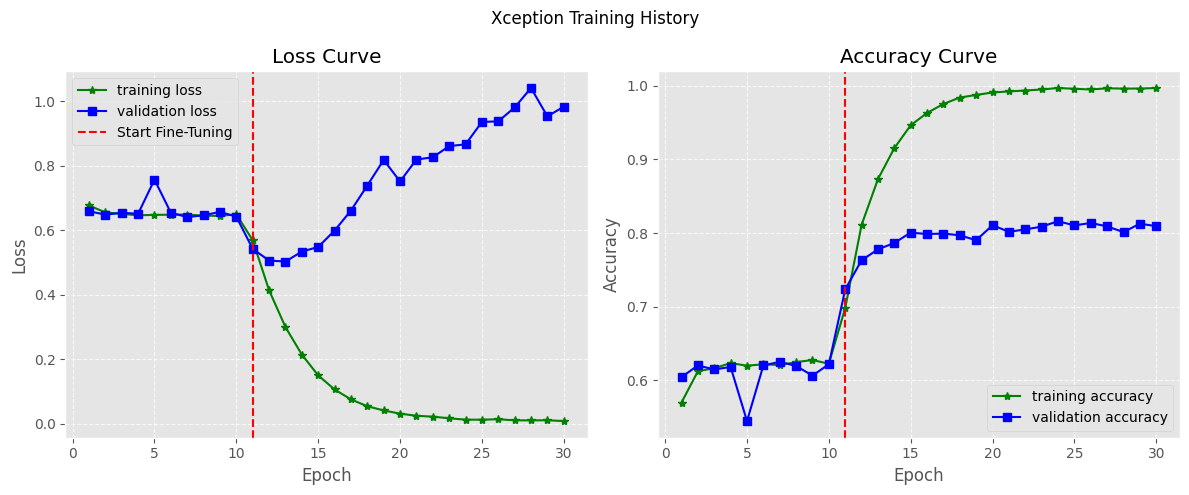

In [27]:
save_path = f"{project_root}/results/{MODEL_NAME}_finetuned_{TASK_NAME}.png"
plot_history(
    history,
    "Xception Training History",
    save_path=save_path,
    start_finetuned_epoch=EPOCHS_STAGE_1 + 1,
)

In [28]:
# Load the model again
checkpoint = torch.load(model_save_path)
model.load_state_dict(checkpoint["state_dict"])

<All keys matched successfully>

Getting predictions: 100%|██████████| 95/95 [00:40<00:00,  2.32it/s]


Accuracy score: 0.8060
Classification Report
              precision    recall  f1-score   support

           0       0.84      0.75      0.79      1510
           1       0.78      0.86      0.82      1510

    accuracy                           0.81      3020
   macro avg       0.81      0.81      0.81      3020
weighted avg       0.81      0.81      0.81      3020



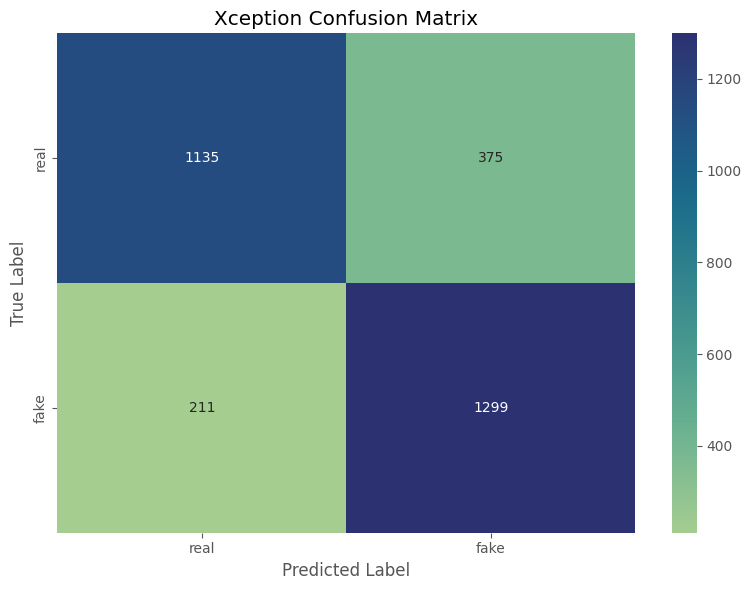

In [29]:
save_path = f"{project_root}/results/{MODEL_NAME}_{TASK_NAME}_finetuned_cfm.png"
performance(model, test_loader, DEVICE, MODEL_NAME, save_path = save_path)

In [30]:
# Save history
json_path = os.path.join(project_root, f"results/{MODEL_NAME}_{TASK_NAME}_finetuned_history.json")
save_experiment_json(history, json_path)

History saved to /Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/results/Xception_deepfake_detection_finetuned_history.json


## 2. Xception Training with Data Augmentation, Label Smoothing and Weight Decay

In [31]:
train_loader, val_loader, test_loader = get_data_loaders(root_dir = data_path, 
                                                         model_name = MODEL_NAME, 
                                                         batch_size = BATCH_SIZE, 
                                                         use_augmentation = True)

/Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/.venv/lib/python3.11/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6225708].


(np.float64(-0.5), np.float64(298.5), np.float64(298.5), np.float64(-0.5))

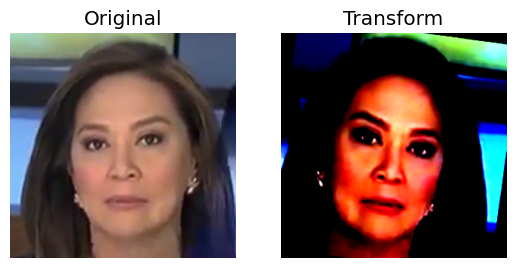

In [32]:
original_images_batch, transformed_images_batch, labels_batch = next(iter(train_loader))

plt.subplot(1, 2, 1)
plt.imshow(original_images_batch[0])
plt.title("Original")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Transform")
plt.imshow(transformed_images_batch[0].permute(1, 2, 0))
plt.axis("off")

###  2.1 Train head only

In [33]:
model = XceptionDF()
torchsummary.summary(model, (3, 299, 299), batch_size=32)

/Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/.venv/lib/python3.11/site-packages/timm/models/_factory.py:138: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [32, 32, 149, 149]             864
       BatchNorm2d-2         [32, 32, 149, 149]              64
              ReLU-3         [32, 32, 149, 149]               0
            Conv2d-4         [32, 64, 147, 147]          18,432
       BatchNorm2d-5         [32, 64, 147, 147]             128
              ReLU-6         [32, 64, 147, 147]               0
            Conv2d-7         [32, 64, 147, 147]             576
            Conv2d-8        [32, 128, 147, 147]           8,192
   SeparableConv2d-9        [32, 128, 147, 147]               0
      BatchNorm2d-10        [32, 128, 147, 147]             256
             ReLU-11        [32, 128, 147, 147]               0
           Conv2d-12        [32, 128, 147, 147]           1,152
           Conv2d-13        [32, 128, 147, 147]          16,384
  SeparableConv2d-14        [32, 128, 1

In [34]:
model = model.to(device=DEVICE)
LABEL_SMOOTHING = 0.1
WEIGHT_DECAY = 1e-2

optimizer = torch.optim.Adam(params=model.parameters(), lr=LR_STAGE_1, weight_decay=WEIGHT_DECAY)
criterion = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTHING)

In [35]:
history_aug = {
    'model_name': MODEL_NAME,
    'model_saved_path': '',
    'weight_decay': WEIGHT_DECAY,
    'label_smoothing': LABEL_SMOOTHING,
    'train_losses': [],
    'val_losses': [],
    'train_accuracy': [],
    'val_accuracy': [],
    'val_f1': [],
    'val_auc': [],
    'best_accuracy': [],
    'best_epoch': [],
}

best_acc = 0.0

In [36]:

MODEL_SAVED_PATH = os.path.join(
    project_root, f"model_checkpoints/{MODEL_NAME}_augmentation_{TASK_NAME}.pth"
)

print(f"Training configuration for stage 1: LR = {LR_STAGE_1}, EPOCHS = {EPOCHS_STAGE_1}")

for epoch in range(EPOCHS_STAGE_1):
    # Train
    train_loss, train_acc = train_one_epoch(
        model, train_loader, criterion, optimizer, DEVICE
    )

    # Evaluate
    valid_loss, valid_acc, valid_f1, valid_auc = evaluate(
        model, val_loader, criterion, DEVICE
    )

    print(
        f"[{epoch + 1}/{EPOCHS_STAGE_1}] train_acc: {train_acc:.4f} - train_loss: {train_loss:.4f} - valid_acc: {valid_acc:.4f} - valid_loss: {valid_loss:.4f}"
    )
    # Record metrics
    history_aug["train_losses"].append(train_loss)
    history_aug["val_losses"].append(valid_loss)
    history_aug["train_accuracy"].append(train_acc)
    history_aug["val_accuracy"].append(valid_acc)
    history_aug["val_f1"].append(valid_f1)
    history_aug["val_auc"].append(valid_auc)

    # Save Best Model (based on Accuracy)
    if valid_acc > best_acc:
        best_acc = valid_acc
        save_checkpoint(model, optimizer, MODEL_SAVED_PATH)

        # Update best stats
        history_aug["best_accuracy"] = best_acc
        history_aug["best_epoch"] = epoch + 1
        history_aug["MODEL_SAVED_PATH"] = MODEL_SAVED_PATH

    print(
        f"\t- [current best] epoch: {history_aug['best_epoch']} - acc: {history_aug['best_accuracy']:.4f}\n"
    )

Training configuration for stage 1: LR = 0.001, EPOCHS = 10


Evaluating: 100%|██████████| 94/94 [00:40<00:00,  2.31it/s]


[1/10] train_acc: 0.5636 - train_loss: 0.6829 - valid_acc: 0.5721 - valid_loss: 0.6816
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/model_checkpoints/Xception_augmentation_deepfake_detection.pth
	- [current best] epoch: 1 - acc: 0.5721



Evaluating: 100%|██████████| 94/94 [00:40<00:00,  2.31it/s]


[2/10] train_acc: 0.6020 - train_loss: 0.6702 - valid_acc: 0.5577 - valid_loss: 0.6873
	- [current best] epoch: 1 - acc: 0.5721



Evaluating: 100%|██████████| 94/94 [00:42<00:00,  2.23it/s]


[3/10] train_acc: 0.6011 - train_loss: 0.6713 - valid_acc: 0.6225 - valid_loss: 0.6619
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/model_checkpoints/Xception_augmentation_deepfake_detection.pth
	- [current best] epoch: 3 - acc: 0.6225



Evaluating: 100%|██████████| 94/94 [00:40<00:00,  2.31it/s]


[4/10] train_acc: 0.5996 - train_loss: 0.6694 - valid_acc: 0.5919 - valid_loss: 0.6697
	- [current best] epoch: 3 - acc: 0.6225



Evaluating: 100%|██████████| 94/94 [00:40<00:00,  2.30it/s]


[5/10] train_acc: 0.6073 - train_loss: 0.6655 - valid_acc: 0.6215 - valid_loss: 0.6592
	- [current best] epoch: 3 - acc: 0.6225



Evaluating: 100%|██████████| 94/94 [00:40<00:00,  2.29it/s]


[6/10] train_acc: 0.6060 - train_loss: 0.6666 - valid_acc: 0.6101 - valid_loss: 0.6630
	- [current best] epoch: 3 - acc: 0.6225



Evaluating: 100%|██████████| 94/94 [00:41<00:00,  2.28it/s]


[7/10] train_acc: 0.5972 - train_loss: 0.6711 - valid_acc: 0.6185 - valid_loss: 0.6574
	- [current best] epoch: 3 - acc: 0.6225



Evaluating: 100%|██████████| 94/94 [00:41<00:00,  2.29it/s]


[8/10] train_acc: 0.6061 - train_loss: 0.6666 - valid_acc: 0.6037 - valid_loss: 0.6635
	- [current best] epoch: 3 - acc: 0.6225



Evaluating: 100%|██████████| 94/94 [00:40<00:00,  2.29it/s]


[9/10] train_acc: 0.6068 - train_loss: 0.6652 - valid_acc: 0.6104 - valid_loss: 0.6617
	- [current best] epoch: 3 - acc: 0.6225



Evaluating: 100%|██████████| 94/94 [00:41<00:00,  2.29it/s]

[10/10] train_acc: 0.6018 - train_loss: 0.6674 - valid_acc: 0.6037 - valid_loss: 0.6659
	- [current best] epoch: 3 - acc: 0.6225



In [37]:
# Load the best state again
checkpoint = torch.load(MODEL_SAVED_PATH)
model.load_state_dict(checkpoint["state_dict"])

<All keys matched successfully>

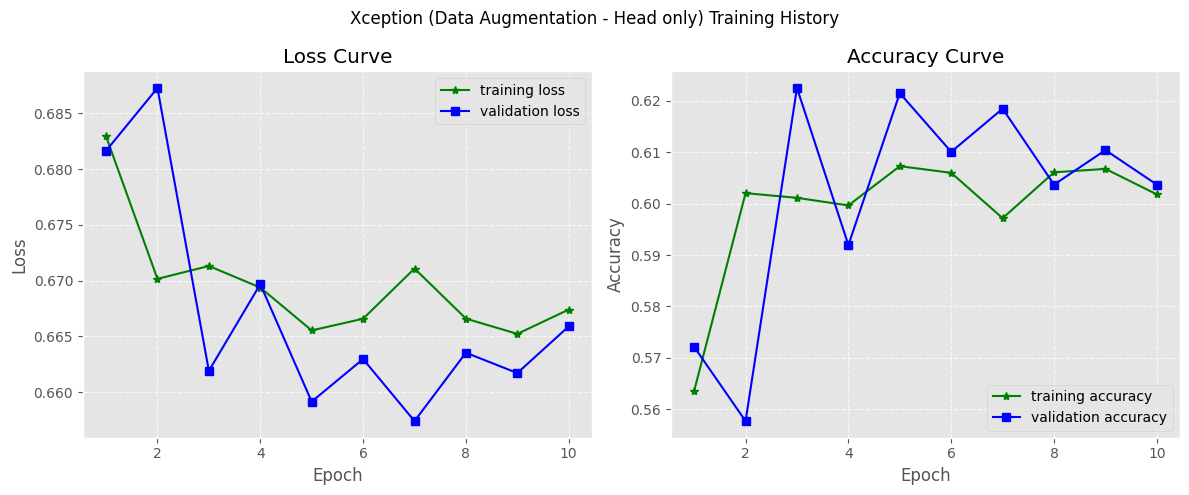

In [38]:
model_saved_name = f"{project_root}/results/{MODEL_NAME}_augmentation_{TASK_NAME}"
plot_history(
    history_aug,
    "Xception (Data Augmentation - Head only) Training History",
    f"{model_saved_name}.png",
)

## 2.2 Finetuning the model: Unfreezing few layers

In [39]:
# Get number of blocks
blocks = list(model.model.named_children())
print("Number of blocks: ", len(blocks))
# Unfreeze more half of the model
num_blocks_to_unfreeze = len(blocks) // 2
for name, module in blocks[-num_blocks_to_unfreeze:]:
    print("Unfreeze block: ", name)
    for param in module.parameters():
        param.requires_grad = True

torchsummary.summary(model.to('cpu'), (3, 299, 299))

Number of blocks:  26
Unfreeze block:  block8
Unfreeze block:  block9
Unfreeze block:  block10
Unfreeze block:  block11
Unfreeze block:  block12
Unfreeze block:  conv3
Unfreeze block:  bn3
Unfreeze block:  act3
Unfreeze block:  conv4
Unfreeze block:  bn4
Unfreeze block:  act4
Unfreeze block:  global_pool
Unfreeze block:  fc
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 149, 149]             864
       BatchNorm2d-2         [-1, 32, 149, 149]              64
              ReLU-3         [-1, 32, 149, 149]               0
            Conv2d-4         [-1, 64, 147, 147]          18,432
       BatchNorm2d-5         [-1, 64, 147, 147]             128
              ReLU-6         [-1, 64, 147, 147]               0
            Conv2d-7         [-1, 64, 147, 147]             576
            Conv2d-8        [-1, 128, 147, 147]           8,192
   SeparableConv2d-9        [-1, 

In [40]:
model = model.to(device=DEVICE)
LABEL_SMOOTHING = 0.1
WEIGHT_DECAY = 1e-2

optimizer = torch.optim.Adam(params=model.parameters(), lr=LR_STAGE_2, weight_decay=WEIGHT_DECAY)
criterion = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTHING)

In [41]:
TOTAL_EPOCHS = EPOCHS_STAGE_1 + EPOCHS_STAGE_2
model_save_path = f"{project_root}/model_checkpoints/best_{MODEL_NAME}_{TASK_NAME}_finetuned.pth"

print(f"Training configuration for stage 2: LR = {LR_STAGE_2}, EPOCHS = {EPOCHS_STAGE_2}")
for epoch in range(EPOCHS_STAGE_1, TOTAL_EPOCHS):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, DEVICE)
    valid_loss, valid_acc, valid_f1, valid_auc = evaluate(model, val_loader, criterion, DEVICE)
    
    print(f"[{epoch + 1}/{TOTAL_EPOCHS} (Fine-Tune)] train_acc: {train_acc:.4f} - train_loss: {train_loss:.4f} - valid_acc: {valid_acc:.4f} - valid_loss: {valid_loss:.4f}")
    
    # Record metrics
    history_aug["train_losses"].append(train_loss)
    history_aug["val_losses"].append(valid_loss)
    history_aug["train_accuracy"].append(train_acc)
    history_aug["val_accuracy"].append(valid_acc)
    history_aug["val_f1"].append(valid_f1)
    history_aug["val_auc"].append(valid_auc)

    # Save Best Model (based on Accuracy)
    if valid_acc > best_acc:
        best_acc = valid_acc
        save_checkpoint(model, optimizer, model_save_path)

        # Update best stats
        history_aug["best_accuracy"] = best_acc
        history_aug["best_epoch"] = epoch + 1
        history_aug["MODEL_SAVED_PATH"] = model_save_path
        
    print(f"\t- [current best] epoch: {history_aug['best_epoch']} - acc: {history_aug['best_accuracy']:.4f}\n")

Training configuration for stage 2: LR = 1e-05, EPOCHS = 20


Evaluating: 100%|██████████| 94/94 [00:41<00:00,  2.25it/s]


[11/30 (Fine-Tune)] train_acc: 0.6628 - train_loss: 0.6279 - valid_acc: 0.7013 - valid_loss: 0.6011
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/model_checkpoints/best_Xception_deepfake_detection_finetuned.pth
	- [current best] epoch: 11 - acc: 0.7013



Evaluating: 100%|██████████| 94/94 [00:41<00:00,  2.28it/s]


[12/30 (Fine-Tune)] train_acc: 0.7387 - train_loss: 0.5585 - valid_acc: 0.7500 - valid_loss: 0.5504
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/model_checkpoints/best_Xception_deepfake_detection_finetuned.pth
	- [current best] epoch: 12 - acc: 0.7500



Evaluating: 100%|██████████| 94/94 [00:41<00:00,  2.29it/s]


[13/30 (Fine-Tune)] train_acc: 0.8027 - train_loss: 0.4894 - valid_acc: 0.7745 - valid_loss: 0.5311
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/model_checkpoints/best_Xception_deepfake_detection_finetuned.pth
	- [current best] epoch: 13 - acc: 0.7745



Evaluating: 100%|██████████| 94/94 [00:41<00:00,  2.27it/s]


[14/30 (Fine-Tune)] train_acc: 0.8382 - train_loss: 0.4449 - valid_acc: 0.7775 - valid_loss: 0.5400
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/model_checkpoints/best_Xception_deepfake_detection_finetuned.pth
	- [current best] epoch: 14 - acc: 0.7775



Evaluating: 100%|██████████| 94/94 [00:41<00:00,  2.29it/s]


[15/30 (Fine-Tune)] train_acc: 0.8661 - train_loss: 0.4111 - valid_acc: 0.7926 - valid_loss: 0.5204
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/model_checkpoints/best_Xception_deepfake_detection_finetuned.pth
	- [current best] epoch: 15 - acc: 0.7926



Evaluating: 100%|██████████| 94/94 [00:41<00:00,  2.28it/s]


[16/30 (Fine-Tune)] train_acc: 0.8848 - train_loss: 0.3853 - valid_acc: 0.7909 - valid_loss: 0.5372
	- [current best] epoch: 15 - acc: 0.7926



Evaluating: 100%|██████████| 94/94 [00:41<00:00,  2.28it/s]


[17/30 (Fine-Tune)] train_acc: 0.9008 - train_loss: 0.3654 - valid_acc: 0.8084 - valid_loss: 0.5076
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/model_checkpoints/best_Xception_deepfake_detection_finetuned.pth
	- [current best] epoch: 17 - acc: 0.8084



Evaluating: 100%|██████████| 94/94 [00:41<00:00,  2.27it/s]


[18/30 (Fine-Tune)] train_acc: 0.9150 - train_loss: 0.3475 - valid_acc: 0.8188 - valid_loss: 0.5012
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/model_checkpoints/best_Xception_deepfake_detection_finetuned.pth
	- [current best] epoch: 18 - acc: 0.8188



Evaluating: 100%|██████████| 94/94 [00:41<00:00,  2.25it/s]


[19/30 (Fine-Tune)] train_acc: 0.9236 - train_loss: 0.3345 - valid_acc: 0.8081 - valid_loss: 0.5060
	- [current best] epoch: 18 - acc: 0.8188



Evaluating: 100%|██████████| 94/94 [00:41<00:00,  2.27it/s]


[20/30 (Fine-Tune)] train_acc: 0.9307 - train_loss: 0.3264 - valid_acc: 0.8158 - valid_loss: 0.5076
	- [current best] epoch: 18 - acc: 0.8188



Evaluating: 100%|██████████| 94/94 [00:41<00:00,  2.26it/s]


[21/30 (Fine-Tune)] train_acc: 0.9401 - train_loss: 0.3126 - valid_acc: 0.8158 - valid_loss: 0.5155
	- [current best] epoch: 18 - acc: 0.8188



Evaluating: 100%|██████████| 94/94 [00:41<00:00,  2.28it/s]


[22/30 (Fine-Tune)] train_acc: 0.9423 - train_loss: 0.3094 - valid_acc: 0.8336 - valid_loss: 0.4844
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/model_checkpoints/best_Xception_deepfake_detection_finetuned.pth
	- [current best] epoch: 22 - acc: 0.8336



Evaluating: 100%|██████████| 94/94 [00:41<00:00,  2.29it/s]


[23/30 (Fine-Tune)] train_acc: 0.9486 - train_loss: 0.3003 - valid_acc: 0.8057 - valid_loss: 0.5448
	- [current best] epoch: 22 - acc: 0.8336



Evaluating: 100%|██████████| 94/94 [00:41<00:00,  2.27it/s]


[24/30 (Fine-Tune)] train_acc: 0.9512 - train_loss: 0.2972 - valid_acc: 0.8369 - valid_loss: 0.4839
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/model_checkpoints/best_Xception_deepfake_detection_finetuned.pth
	- [current best] epoch: 24 - acc: 0.8369



Evaluating: 100%|██████████| 94/94 [00:40<00:00,  2.33it/s]


[25/30 (Fine-Tune)] train_acc: 0.9564 - train_loss: 0.2913 - valid_acc: 0.8386 - valid_loss: 0.4817
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/model_checkpoints/best_Xception_deepfake_detection_finetuned.pth
	- [current best] epoch: 25 - acc: 0.8386



Evaluating: 100%|██████████| 94/94 [00:40<00:00,  2.32it/s]


[26/30 (Fine-Tune)] train_acc: 0.9564 - train_loss: 0.2877 - valid_acc: 0.8443 - valid_loss: 0.4695
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/model_checkpoints/best_Xception_deepfake_detection_finetuned.pth
	- [current best] epoch: 26 - acc: 0.8443



Evaluating: 100%|██████████| 94/94 [00:41<00:00,  2.29it/s]


[27/30 (Fine-Tune)] train_acc: 0.9594 - train_loss: 0.2833 - valid_acc: 0.8436 - valid_loss: 0.4707
	- [current best] epoch: 26 - acc: 0.8443



Evaluating: 100%|██████████| 94/94 [00:41<00:00,  2.28it/s]


[28/30 (Fine-Tune)] train_acc: 0.9593 - train_loss: 0.2806 - valid_acc: 0.8426 - valid_loss: 0.4709
	- [current best] epoch: 26 - acc: 0.8443



Evaluating: 100%|██████████| 94/94 [00:41<00:00,  2.29it/s]


[29/30 (Fine-Tune)] train_acc: 0.9615 - train_loss: 0.2798 - valid_acc: 0.8513 - valid_loss: 0.4683
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/model_checkpoints/best_Xception_deepfake_detection_finetuned.pth
	- [current best] epoch: 29 - acc: 0.8513



Evaluating: 100%|██████████| 94/94 [00:41<00:00,  2.28it/s]

[30/30 (Fine-Tune)] train_acc: 0.9628 - train_loss: 0.2740 - valid_acc: 0.8228 - valid_loss: 0.5188
	- [current best] epoch: 29 - acc: 0.8513



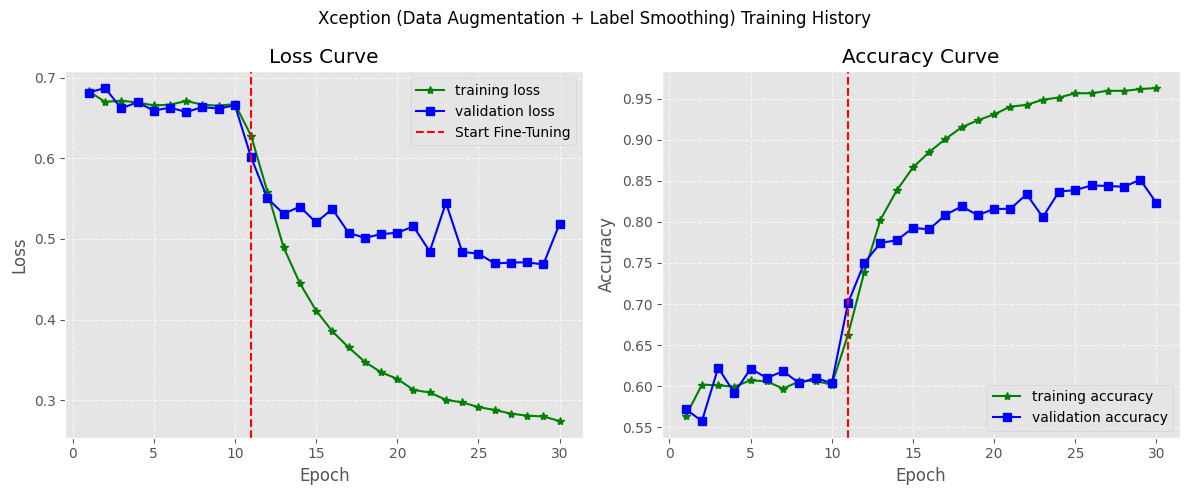

In [45]:
model_saved_name = f"{project_root}/results/{MODEL_NAME}_augmentation_finetuned_{TASK_NAME}"
plot_history(
    history_aug,
    "Xception (Data Augmentation + Label Smoothing) Training History",
    f"{model_saved_name}.png",
    start_finetuned_epoch=EPOCHS_STAGE_1 + 1
    
)

In [43]:
# Load the model again
checkpoint = torch.load(model_save_path)
model.load_state_dict(checkpoint["state_dict"])

<All keys matched successfully>

Getting predictions: 100%|██████████| 95/95 [00:41<00:00,  2.31it/s]


Accuracy score: 0.8411
Classification Report
              precision    recall  f1-score   support

           0       0.85      0.83      0.84      1510
           1       0.83      0.86      0.84      1510

    accuracy                           0.84      3020
   macro avg       0.84      0.84      0.84      3020
weighted avg       0.84      0.84      0.84      3020



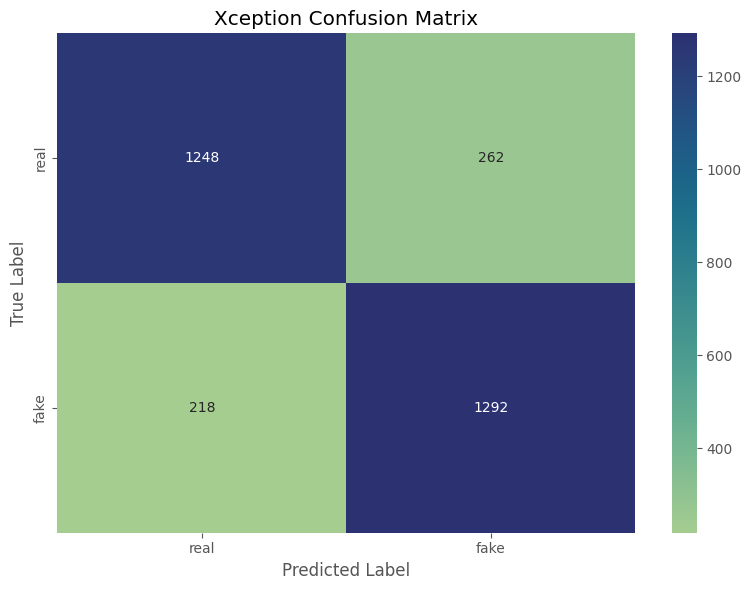

In [44]:
save_path = f"{project_root}/results/{MODEL_NAME}_{TASK_NAME}_augmentation_finetuned_cfm.png"
performance(model, test_loader, DEVICE, MODEL_NAME, save_path = save_path)